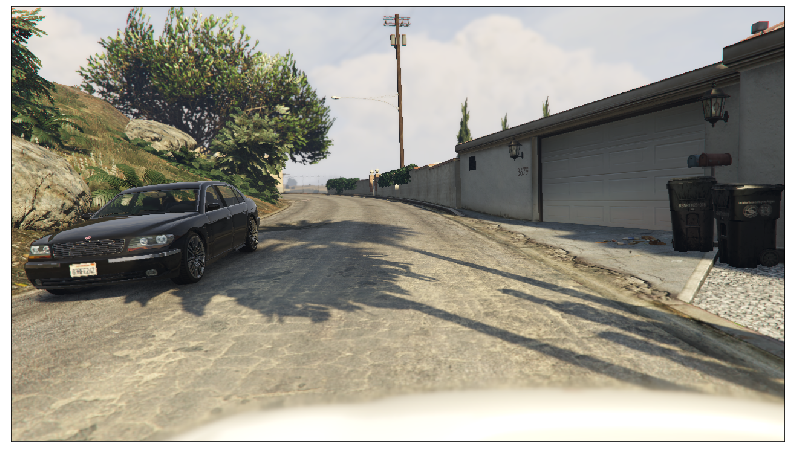

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import partial

from tqdm.notebook import tqdm, trange

import sys
sys.path.append('../')

from depth_Functions import (
    show_img,
    show_array_of_images,
    show_function,
    import_raw_colour_image
)

from Feature_Extraction import (
    calculate_local_features,
    titles
)

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr);

from Global import *

# Creating an array of features

In [18]:
local_features = calculate_local_features(bgr, convert=cv2.COLOR_BGR2YCrCb)

# Neighbours

In [19]:
show_function(calc_neighbours)

def calc_neighbours(image, n=1):
    tuples = np.array([(0,0) for i in range(len(image.shape))])
    up    = np.pad(image[:-n],  ((1,0),*tuples[1:]), mode='edge')
    right = np.pad(image[:,n:], ((0,0),(0,1),*tuples[2:]), mode='edge')
    down  = np.pad(image[n:],   ((0,1),*tuples[1:]), mode='edge')
    left  = np.pad(image[:,:-n],((0,0),(1,0),*tuples[2:]), mode='edge')    
    return np.stack([image, up, right, down, left], axis=-2)

In [20]:
neighbours = calc_neighbours(local_features)

In [21]:
neighbours.shape

(720, 1280, 5, 17)

In [22]:
np.all(neighbours[:,:,0] == local_features)
np.all(neighbours[0,:,1] == local_features[0]) and np.all([neighbours[i,:,1] == local_features[i-1] for i in range(1,neighbours.shape[0])])
np.all(neighbours[:,-1,2] == local_features[:,-1]) and np.all([neighbours[:,i,2] == local_features[:,i+1] for i in range(0,neighbours.shape[0]-1)])
np.all(neighbours[-1,:,3] == local_features[-1]) and np.all([neighbours[i,:,3] == local_features[i+1] for i in range(0,neighbours.shape[0]-1)])
np.all(neighbours[:,0,4] == local_features[:,0]) and np.all([neighbours[:,i,4] == local_features[:,i-1] for i in range(1,neighbours.shape[0])])

True

True

True

True

True

# Scales

For ease of storing when incorporating scales the image is split into patches. Now instead an array of dimensions of y,x,f, we have py,px,n,f. py and px are the number of patches in the image in that axis, f remains the number of features and n is the sum of the product of the dimenions of the scale of each patch.

In order to get patches of an array we need to ensure the y,x axis are multiples of the y,x patch shape. If not we need to pad the relevant axis.

**n.b. vertical and horizontal behave differently regarding padding. Both use the same padding mode, which in this case is reflect. All padding for rows are added at the top of the image: accurate measurement of the top of the image is less significant as often further away and reflection frequently represents the top of the image better as it often contains sky. The horizontal image looks to spread the excess evenly to left and right sides of the image.**

In [23]:
show_function(patch_pad)

def patch_pad(image, patchshape, remove=False):
    y_modulus = image.shape[0]%patchshape[0]
    x_modulus = image.shape[1]%patchshape[1]
    
    if y_modulus==x_modulus==0:
        return image

    y_shift = 0 if y_modulus==0 else patchshape[0]-y_modulus
    x_shift = 0 if x_modulus==0 else patchshape[1]-x_modulus
    y_pad = (y_shift,0)
    x_pad = (x_shift//2, math.ceil(x_shift/2))
    # print(y_pad, x_pad)
    if remove:
        return image[y_pad[0]:y_pad[1], x_pad[0]:x_pad[1]]

    empty = [(0,0) for i in range(len(image.shape)-2)]
    return np.pad(image, (y_pad, x_pad, *empty), mode='reflect')

We get a patch by applying a given function, generally np.sum, over each patch. This is simplest done by reshaping the array then applying teh function along the necessary axes.  

All the scales are stored in the same array. The first max_scale*max_scale arrays of the third dimension are the unscaled features. 

In [24]:
show_function(calc_scales)

def calc_scales(image, patch_function, relative_scales):
    t_mul = lambda *tuples : np.product(tuples,axis=0) 
    scales = list(accumulate(relative_scales, t_mul))
    return [calc_patches(image, patch_function, scale) for scale in scales]

In [54]:
scale_1,scale_3,scale_9 = calc_scales(local_features, np.sum, [(1,1),(3,3),(3,3)])

In [55]:
scale_1.shape 
scale_3.shape 
scale_9.shape 

(720, 1280, 17)

(240, 427, 17)

(80, 143, 17)

For an image shape of 720,1280 and a patchshape of (9,9), the vertical patches will fit exactly but the first horizontal patches will be padded by 3 pixels to the left, 4 to the right.

## 1x1

In [56]:
np.all(scale_1 == local_features)

True

## 3x3

For a scale of 3x3 patches the image will need no vertical padding and pad one pixel to the right of the image. 

In [70]:
'All but last column', np.all([np.round(scale_3[0][i],6) == np.round(np.sum(local_features[0:3,i*3:i*3+3], axis=(0,1)),6) for i in range(scale_3.shape[1]-1)])
'last column', np.all(np.round(scale_3[0][-1],6) == np.round(np.sum(local_features[0:3,[-2,-1,-2]], axis=(0,1)),6))

'all rows', np.all([np.round(scale_3[i][0],6) == np.round(np.sum(local_features[i*3:i*3+3,0:3], axis=(0,1)),6) for i in range(1)])

('All but last column', True)

('last column', True)

('all rows', True)

## 9x9

For a scale of 3x3 patches the image will need no vertical padding, 3 pixels to the left and 4 to the right.

In [71]:
'first column', np.all(np.round(scale_9[0][0],6) == np.round(np.sum(local_features[0:9,[*range(1,4),*range(0,6)]], axis=(0,1)),6))
'mid section', np.all([np.round(scale_9[0][i],6) == np.round(np.sum(local_features[0:9,9*i-3:9*i+6], axis=(0,1)),6) for i in range(1,scale_9.shape[1]-1)])
'last column', np.all(np.round(scale_9[0][-1],6) == np.round(np.sum(local_features[0:9,[*range(-5,0), *range(-5,-1)]], axis=(0,1)),6))

'all rows', np.all([np.round(scale_9[i][1],6) == np.round(np.sum(local_features[i*9:i*9+9,6:15], axis=(0,1)),6) for i in range(scale_9.shape[0])])

('first column', True)

('mid section', True)

('last column', True)

('all rows', True)

In [72]:
padded_local_features = patch_pad(local_features, (9,9))

In [73]:
padded_local_features.shape

(720, 1287, 17)

For each scale below the largest there are n values representing each scale, where n is the current scale relative to the largest. In this case it's (3,3), which is represented by 9 elements per patch.

For an image shape of 720,1280 and a patchshape of (3,3), the vertical patches will fit exactly but the first horizontal patches will repeat the far right pixel of each row.

# Relative Histogram

The relative depth between pixels will be 0 (or close to), more information is contained in the difference in depth between patches. We therefore focus on approximating the relative depth between patches.

For estimating the relative depths between patches we take the difference between the histogram of two patches.

In [30]:
show_function(calc_relative_histograms)
show_function(calc_histograms)

def calc_relative_histograms(patches, bins, axis, *kwargs):
    histograms = calc_histograms(patches, bins, axis, *kwargs)
    return calc_relative(histograms)

def calc_histograms(patches, bins, axis):
    bins = bins[:,:-1]
    digitised = np.stack([np.digitize(patches[...,f], bins[f], right=False) for f in range(bins.shape[0])],axis=-1)

    return np.sum(np.identity(bins.shape[-1])[digitised-1], axis=axis)

In [31]:
patches = padded_local_features.reshape(80,9,143,9,17)

In [32]:
bins = calc_bins(local_features)

In [33]:
histograms = calc_histograms(patches, bins, axis=(1,3))

In [34]:
histograms.shape

(80, 143, 17, 10)

In [35]:
np.all([histograms[y,x] == [np.histogram(padded_local_features[9*y:9*y+9,9*x:9*x+9,f], bins=bins[f])[0] for f in range(local_features.shape[-1])] for y,x in tqdm(product(range(80), range(143)), leave=False, total=80*143)])

True

In [36]:
scaled_histograms = calc_scales(local_features, partial(calc_histograms, bins=bins), [(3,3),(3,3)])

In [37]:
scaled_histograms.shape

(80, 143, 10, 17, 10)

In [38]:
np.all(scaled_histograms[:,:,-1] == histograms)

True

In [39]:
np.all([ 
np.all(scaled_histograms[0][0][0] == [np.histogram(padded_local_features[0:3,0:3,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),
np.all(scaled_histograms[0][0][1] == [np.histogram(padded_local_features[0:3,3:6,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),
np.all(scaled_histograms[0][0][2] == [np.histogram(padded_local_features[0:3,6:9,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),

np.all(scaled_histograms[0][0][3] == [np.histogram(padded_local_features[3:6,0:3,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),
np.all(scaled_histograms[0][0][4] == [np.histogram(padded_local_features[3:6,3:6,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),
np.all(scaled_histograms[0][0][5] == [np.histogram(padded_local_features[3:6,6:9,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),

np.all(scaled_histograms[0][0][6] == [np.histogram(padded_local_features[6:9,0:3,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),
np.all(scaled_histograms[0][0][7] == [np.histogram(padded_local_features[6:9,3:6,f], bins=bins[f])[0] for f in range(local_features.shape[-1])]),
np.all(scaled_histograms[0][0][8] == [np.histogram(padded_local_features[6:9,6:9,f], bins=bins[f])[0] for f in range(local_features.shape[-1])])
])

True

In [40]:
relative_histograms = calc_scales(local_features, partial(calc_relative_histograms, bins=bins), [(3,3), (9,9)])

# Complete

In [41]:
global_features = calc_features(bgr, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb), neighbours=True, patch_function=np.sum, relative_scales=[(1,1), (3,3), (3,3)])

In [42]:
global_features.shape

(80, 143, 91, 5, 17)

# Dot product

In [48]:
gray_scales = calc_features(bgr, partial(cv2.cvtColor, code=cv2.COLOR_BGR2GRAY), neighbours=True, patch_function=np.sum, relative_scales=[(1,1),(3,3)])

In [49]:
gray_scales.shape

(240, 427, 5, 10)

In [51]:
gray_patches = calc_scales(cv2.cvtColor(bgr, code=cv2.COLOR_BGR2GRAY), None, relative_scales=[(3,3)])

In [52]:
gray_patches.shape

(240, 427, 3, 3)

In [66]:
weights = np.full((5*10,3*3), 1e-4)

In [67]:
prediction = gray_scales.reshape(240,427,-1) @ weights

In [68]:
prediction.shape

(240, 427, 9)

In [69]:
np.all(prediction.flatten() == gray_patches.flatten())

False

In [70]:
prediction.reshape(240,427,3,3)[0][0]

array([[2.016, 2.016, 2.016],
       [2.016, 2.016, 2.016],
       [2.016, 2.016, 2.016]])

In [71]:
gray_patches[0][0]

array([[231, 231, 231],
       [231, 231, 231],
       [230, 231, 231]], dtype=uint8)